Enter the stock code:  STB


Overall Signals Summary: {'Buy': 2766, 'Sell': 3015, 'Neutral': 4989}

Signals for 1 day:
{'Buy': 2, 'Sell': 0, 'Neutral': 4}

Signals for 1 week:
{'Buy': 10, 'Sell': 2, 'Neutral': 18}

Signals for 1 month:
{'Buy': 28, 'Sell': 28, 'Neutral': 64}


C:\Users\HP\AppData\Local\Temp\ipykernel_76\352551074.py:138: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\HP\AppData\Local\Temp\ipykernel_76\352551074.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\HP\AppData\Local\Temp\ipykernel_76\352551074.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

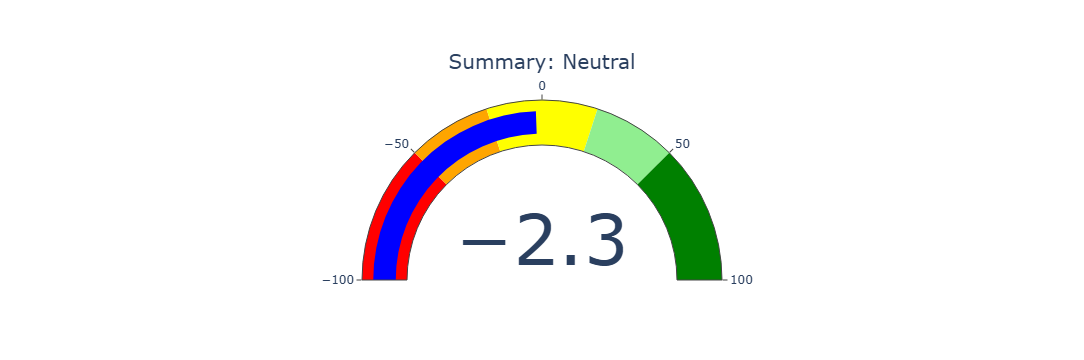

In [23]:
import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator, StochasticOscillator, WilliamsRIndicator
from ta.trend import MACD, SMAIndicator, EMAIndicator
from ta.volatility import BollingerBands
from ta.volume import OnBalanceVolumeIndicator
import plotly.graph_objects as go

# Calculate indicators
def calculate_indicators(data):
    # Oscillators
    data['RSI'] = RSIIndicator(data['PriceLastTransaction'], window=14).rsi()
    data['Stochastic'] = StochasticOscillator(
        data['Max'], data['Min'], data['PriceLastTransaction'], window=14).stoch()
    data['WilliamsR'] = WilliamsRIndicator(
        data['Max'], data['Min'], data['PriceLastTransaction'], lbp=14).williams_r()
    data['OBV'] = OnBalanceVolumeIndicator(data['PriceLastTransaction'], data['Volume']).on_balance_volume()
    bollinger = BollingerBands(data['PriceLastTransaction'], window=20, window_dev=2)
    data['Bollinger_PercentB'] = bollinger.bollinger_pband()

    # Moving Averages
    data['SMA_14'] = SMAIndicator(data['PriceLastTransaction'], window=14).sma_indicator()
    data['SMA_50'] = SMAIndicator(data['PriceLastTransaction'], window=50).sma_indicator()
    data['EMA_14'] = EMAIndicator(data['PriceLastTransaction'], window=14).ema_indicator()
    data['EMA_50'] = EMAIndicator(data['PriceLastTransaction'], window=50).ema_indicator()
    macd = MACD(data['PriceLastTransaction'])
    data['MACD'] = macd.macd()
    data['MACD_Signal'] = macd.macd_signal()
    
    return data

# Generate signals based on indicators
def generate_signals(data):
    signals = {'Buy': 0, 'Sell': 0, 'Neutral': 0}

    # RSI signals
    data['RSI_Signal'] = data['RSI'].apply(lambda x: 'Buy' if x < 30 else ('Sell' if x > 70 else 'Neutral'))
    signals['Buy'] += (data['RSI_Signal'] == 'Buy').sum()
    signals['Sell'] += (data['RSI_Signal'] == 'Sell').sum()
    signals['Neutral'] += (data['RSI_Signal'] == 'Neutral').sum()

    # Stochastic signals
    data['Stochastic_Signal'] = data['Stochastic'].apply(lambda x: 'Buy' if x < 20 else ('Sell' if x > 80 else 'Neutral'))
    signals['Buy'] += (data['Stochastic_Signal'] == 'Buy').sum()
    signals['Sell'] += (data['Stochastic_Signal'] == 'Sell').sum()
    signals['Neutral'] += (data['Stochastic_Signal'] == 'Neutral').sum()

    # Williams %R signals
    data['WilliamsR_Signal'] = data['WilliamsR'].apply(lambda x: 'Buy' if x < -80 else ('Sell' if x > -20 else 'Neutral'))
    signals['Buy'] += (data['WilliamsR_Signal'] == 'Buy').sum()
    signals['Sell'] += (data['WilliamsR_Signal'] == 'Sell').sum()
    signals['Neutral'] += (data['WilliamsR_Signal'] == 'Neutral').sum()

    # Bollinger Percent B signals
    data['Bollinger_Signal'] = data['Bollinger_PercentB'].apply(lambda x: 'Buy' if x < 0 else ('Sell' if x > 1 else 'Neutral'))
    signals['Buy'] += (data['Bollinger_Signal'] == 'Buy').sum()
    signals['Sell'] += (data['Bollinger_Signal'] == 'Sell').sum()
    signals['Neutral'] += (data['Bollinger_Signal'] == 'Neutral').sum()

    # MACD signals
    data['MACD_Signal_Generated'] = data.apply(
        lambda row: 'Buy' if row['MACD'] > row['MACD_Signal'] else ('Sell' if row['MACD'] < row['MACD_Signal'] else 'Neutral'),
        axis=1
    )
    signals['Buy'] += (data['MACD_Signal_Generated'] == 'Buy').sum()
    signals['Sell'] += (data['MACD_Signal_Generated'] == 'Sell').sum()
    signals['Neutral'] += (data['MACD_Signal_Generated'] == 'Neutral').sum()

    # SMA signals
    data['SMA_Signal'] = data.apply(
        lambda row: 'Buy' if row['SMA_14'] > row['SMA_50'] else ('Sell' if row['SMA_14'] < row['SMA_50'] else 'Neutral'),
        axis=1
    )
    signals['Buy'] += (data['SMA_Signal'] == 'Buy').sum()
    signals['Sell'] += (data['SMA_Signal'] == 'Sell').sum()
    signals['Neutral'] += (data['SMA_Signal'] == 'Neutral').sum()

    return signals

# Generate gauge chart
def display_gauge(signals):
    total_signals = sum(signals.values())
    score = (signals['Buy'] - signals['Sell']) / total_signals * 100

    if score > 50:
        summary = "Strong Buy"
    elif 20 < score <= 50:
        summary = "Buy"
    elif -20 <= score <= 20:
        summary = "Neutral"
    elif -50 <= score < -20:
        summary = "Sell"
    else:
        summary = "Strong Sell"

    fig = go.Figure(go.Indicator(
        mode="gauge+number",
        value=score,
        title={'text': f"Summary: {summary}"},
        gauge={
            'axis': {'range': [-100, 100]},
            'bar': {'color': "blue"},
            'steps': [
                {'range': [-100, -50], 'color': "red"},
                {'range': [-50, -20], 'color': "orange"},
                {'range': [-20, 20], 'color': "yellow"},
                {'range': [20, 50], 'color': "lightgreen"},
                {'range': [50, 100], 'color': "green"}]
        }
    ))
    fig.show()

# Evaluate signals over different timeframes
def evaluate_timeframes(data):
    timeframes = {'1 day': 1, '1 week': 5, '1 month': 20}
    for label, days in timeframes.items():
        print(f"\nSignals for {label}:")
        subset = data.tail(days)
        signals = generate_signals(subset)
        print(signals)

# Main script
if __name__ == "__main__":
    try:
        # Read the CSV file
        stock_data = pd.read_csv('mse_data.csv')
        stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%d.%m.%Y')

        # Input for stock code
        stock_code = input("Enter the stock code: ").strip()

        # Filter data based on the entered stock code
        filtered_data = stock_data[stock_data['Code'] == stock_code]

        if filtered_data.empty:
            print(f"No data found for stock code {stock_code}.")
        else:
            filtered_data['Date'] = pd.to_datetime(filtered_data['Date'])
            filtered_data = filtered_data.sort_values(by=['Code', 'Date'])
            
            filtered_data = calculate_indicators(filtered_data)
            signal_summary = generate_signals(filtered_data)
            print("Overall Signals Summary:", signal_summary)
            evaluate_timeframes(filtered_data)
            display_gauge(signal_summary)
            
    except Exception as e:
        print(f"An error occurred: {e}")